In [5]:
# Import necessary libraries
from google.colab import drive
import zipfile
import os

# 1. Mount your Google Drive
drive.mount('/content/drive')

# 2. Define the file paths with the new filename
zip_path = '/content/drive/MyDrive/Hand_Guestures_Recognition.zip'
extract_path = '/content/hand_gesture_dataset'

# Create a directory to extract the files into
os.makedirs(extract_path, exist_ok=True)

# 3. Unzip the file
print(f"Extracting {zip_path} to {extract_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

# 4. List the contents to verify
print("\nContents of the extracted folder:")
!ls /content/hand_gesture_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting /content/drive/MyDrive/Hand_Guestures_Recognition.zip to /content/hand_gesture_dataset...
Extraction complete!

Contents of the extracted folder:
leapgestrecog  leapGestRecog


Found the main dataset directory at: /content/hand_gesture_dataset/leapgestrecog/leapGestRecog

Loading image paths and labels...
Successfully loaded 20000 images.
Found 10 unique gestures.

Displaying a sample of images...


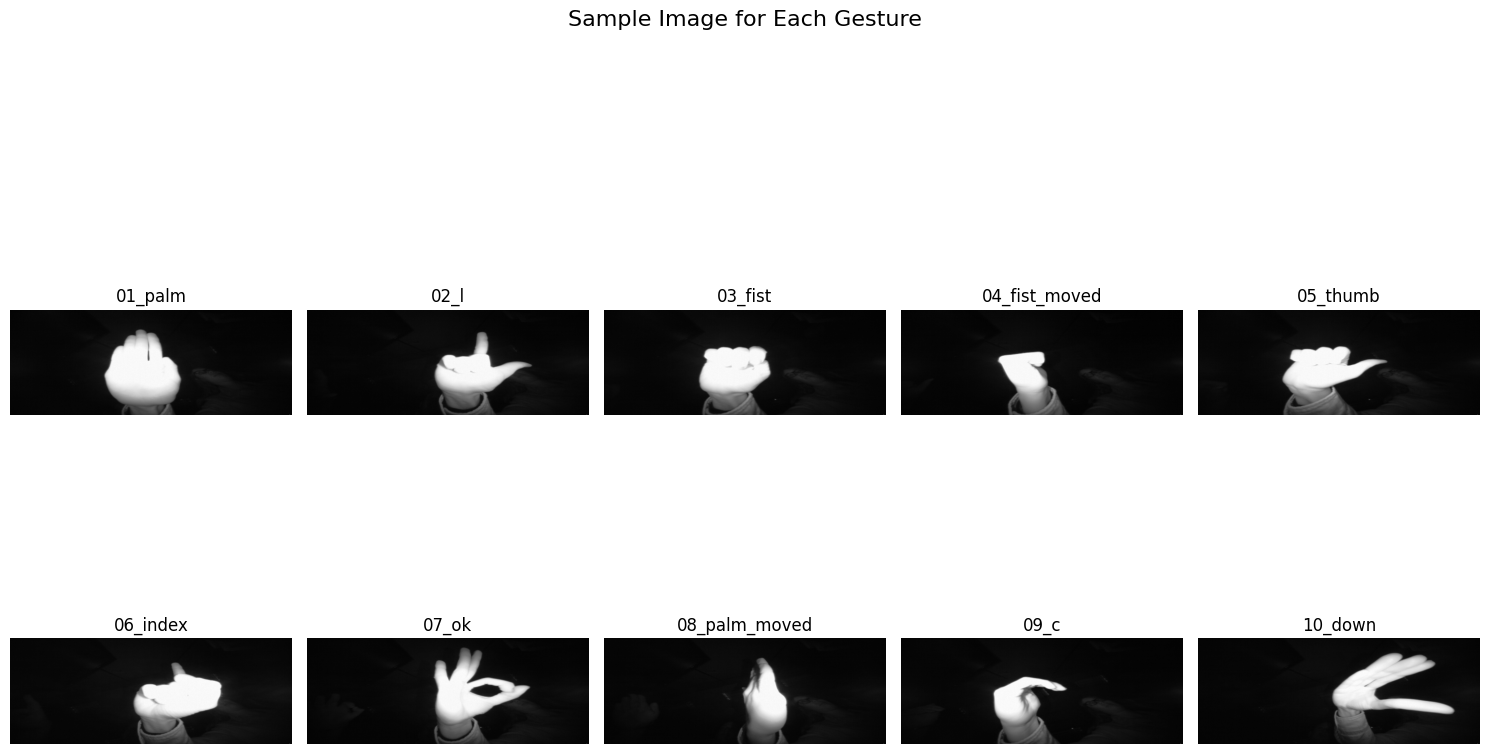

In [6]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Define the base path where you extracted the files
base_dir = '/content/hand_gesture_dataset'

# The dataset is usually nested inside one or two folders after unzipping.
# This code finds the actual directory containing the subject folders (e.g., '00', '01', etc.)
root_dir = base_dir
for dirpath, dirnames, filenames in os.walk(base_dir):
    if '00' in dirnames and '01' in dirnames: # Heuristic to find the right directory
        root_dir = dirpath
        break

print(f"Found the main dataset directory at: {root_dir}")

# --- Now, let's load all image paths and their corresponding labels ---
image_paths = []
labels = []

# The structure is assumed to be: root_dir/subject/gesture/image.png
# e.g., /content/.../leapgestrecog/00/01_palm/frame_00_01_0001.png
print("\nLoading image paths and labels...")
for subject_folder in sorted(os.listdir(root_dir)):
    subject_path = os.path.join(root_dir, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    for gesture_folder in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        for file_name in os.listdir(gesture_path):
            if file_name.endswith('.png'):
                image_paths.append(os.path.join(gesture_path, file_name))
                # The gesture folder name (e.g., '01_palm') is our label
                labels.append(gesture_folder)

print(f"Successfully loaded {len(image_paths)} images.")
print(f"Found {len(np.unique(labels))} unique gestures.")


# --- Let's visualize a few sample images to verify ---
print("\nDisplaying a sample of images...")
plt.figure(figsize=(15, 10))

# Get the list of unique gestures to display one of each
unique_gestures = sorted(list(np.unique(labels)))

for i, gesture_label in enumerate(unique_gestures):
    # Find the first image that matches this gesture
    image_path_sample = next(path for path, label in zip(image_paths, labels) if label == gesture_label)

    # Read the image
    img = cv2.imread(image_path_sample, cv2.IMREAD_GRAYSCALE)

    # Display it
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(gesture_label)
    plt.axis('off')

plt.suptitle("Sample Image for Each Gesture", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2
from tqdm import tqdm

# --- 1. Load, Resize, and Normalize all images ---
IMG_SIZE = 96
X = [] # To store image data
y = [] # To store labels

print("Loading and preprocessing images...")
# image_paths and labels are from the previous cell
for i, path in enumerate(tqdm(image_paths)):
    # Load image in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Resize image
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Normalize pixel values
    img_normalized = img_resized / 255.0
    X.append(img_normalized)
    y.append(labels[i])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"\nImages loaded. Shape of X: {X.shape}")


# --- 2. Encode Text Labels to Numerical Format ---
# Use LabelEncoder to convert string labels to integers (0, 1, 2, ...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Use to_categorical to one-hot encode the integer labels
# e.g., an integer '3' becomes a vector [0, 0, 0, 1, 0, ...]
y_categorical = to_categorical(y_encoded)

print(f"Labels encoded. Shape of y: {y_categorical.shape}")
print(f"Mapping from labels to integers: {list(zip(le.classes_, le.transform(le.classes_)))}")


# --- 3. Split the Data into Training, Validation, and Test sets ---
# First split: 80% for training, 20% for temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Second split: Split the temporary 20% into half for validation and half for testing (10% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Reshape X data to include channel dimension for CNN input (num_samples, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("\nData splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

Loading and preprocessing images...


100%|██████████| 20000/20000 [00:46<00:00, 433.09it/s]



Images loaded. Shape of X: (20000, 96, 96)
Labels encoded. Shape of y: (20000, 10)
Mapping from labels to integers: [(np.str_('01_palm'), np.int64(0)), (np.str_('02_l'), np.int64(1)), (np.str_('03_fist'), np.int64(2)), (np.str_('04_fist_moved'), np.int64(3)), (np.str_('05_thumb'), np.int64(4)), (np.str_('06_index'), np.int64(5)), (np.str_('07_ok'), np.int64(6)), (np.str_('08_palm_moved'), np.int64(7)), (np.str_('09_c'), np.int64(8)), (np.str_('10_down'), np.int64(9))]

Data splitting complete.
X_train shape: (16000, 96, 96, 1)
y_train shape: (16000, 10)
X_val shape:   (2000, 96, 96, 1)
y_val shape:   (2000, 10)
X_test shape:  (2000, 96, 96, 1)
y_test shape:  (2000, 10)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# --- 1. Define the Model Architecture ---
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps and add Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout for regularization

# Output Layer
# 10 neurons because we have 10 gesture classes
# 'softmax' activation for multi-class classification
model.add(Dense(10, activation='softmax'))


# --- Print the model summary ---
model.summary()


# --- 2. Compile the Model ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# --- 3. Train the Model ---
epochs = 15
batch_size = 64

print("\nStarting model training...")
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)
print("Model training complete!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,651,914 (25.38 MB)

 Trainable params: 6,651,914 (25.38 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.7294 - loss: 0.7838 - val_accuracy: 0.9985 - val_loss: 0.0071
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9966 - loss: 0.0139 - val_accuracy: 0.9995 - val_loss: 0.0036
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.9961 - loss: 0.0117 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9970 - loss: 0.0080 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 0.9995 - val_loss: 0.0020
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.9995 - val_loss: 0.0024
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.99

Plotting training history...


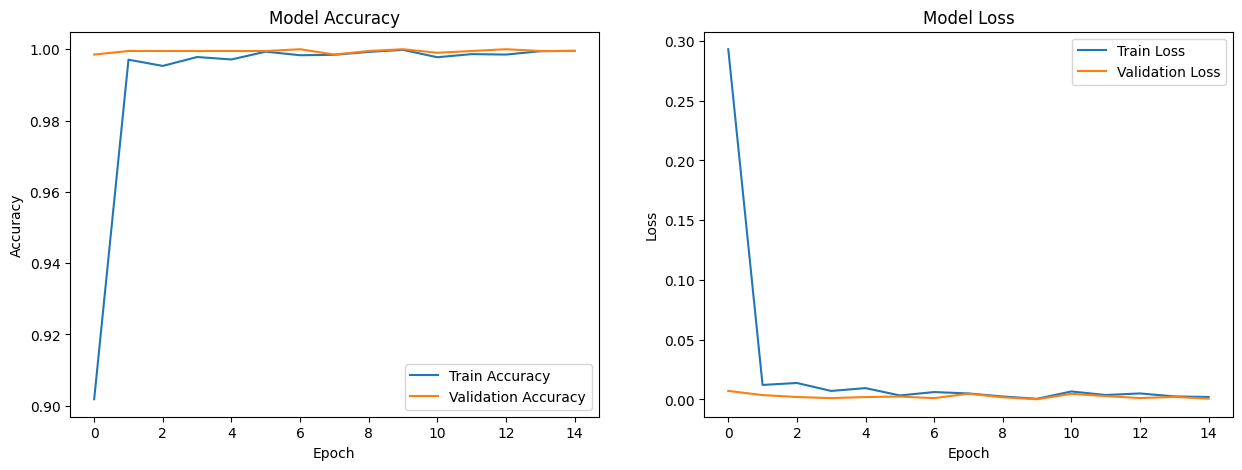


Evaluating model on the test set...
Test Loss: 0.0006
Test Accuracy: 99.95%
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       200
         02_l       1.00      1.00      1.00       200
      03_fist       1.00      1.00      1.00       200
04_fist_moved       1.00      1.00      1.00       200
     05_thumb       1.00      1.00      1.00       200
     06_index       1.00      1.00      1.00       200
        07_ok       1.00      1.00      1.00       200
08_palm_moved       1.00      1.00      1.00       200
         09_c       1.00      0.99      1.00       200
      10_down       1.00      1.00      1.00       200

     accuracy                           1.00      2000
    macro avg       1.00      1.00      1.00      2000
 weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:


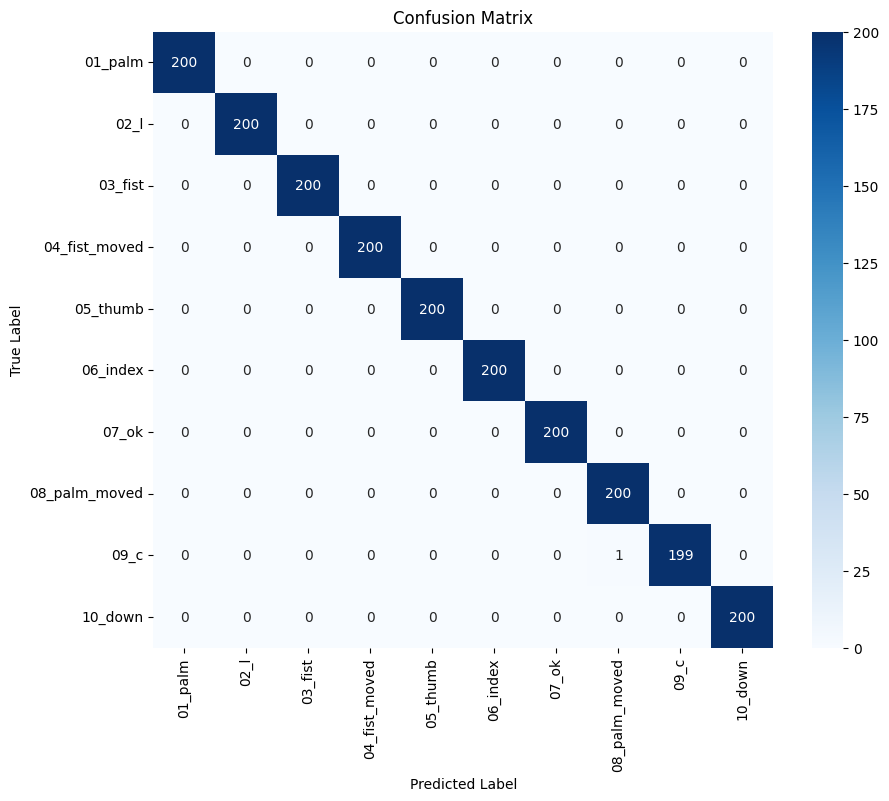

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Plot Training & Validation Accuracy and Loss ---
print("Plotting training history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.show()


# --- 2. Evaluate the Model on the Test Set ---
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


# --- 3. Generate Predictions and Create Classification Report & Confusion Matrix ---
# Get model predictions for the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels from one-hot-encoded to single integer labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
# le.classes_ comes from the LabelEncoder in Step 3
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Generate the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Saving frame_00_09_0001.png to frame_00_09_0001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


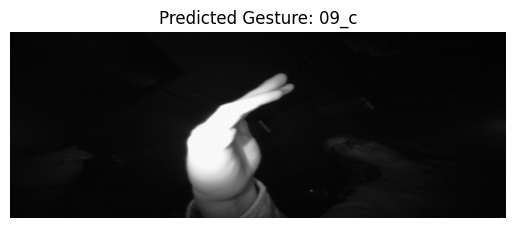

In [12]:
from google.colab import files
import keras.utils as image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# This will prompt you to upload a file
uploaded = files.upload()

# Get the filename of the uploaded image
for fn in uploaded.keys():
  path = fn

  # --- Preprocess the image ---
  # 1. Load the image in grayscale
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  # 2. Resize to the same size as training images (96x96)
  img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

  # 3. Normalize pixel values
  img_normalized = img_resized / 255.0

  # 4. Reshape for the model input (1, height, width, 1)
  img_reshaped = np.reshape(img_normalized, (1, IMG_SIZE, IMG_SIZE, 1))

  # --- Make a prediction ---
  prediction = model.predict(img_reshaped)

  # --- Decode the prediction ---
  # Get the index of the highest probability
  predicted_class_index = np.argmax(prediction)

  # Use the LabelEncoder (le) from Step 3 to get the class name
  predicted_class_name = le.inverse_transform([predicted_class_index])[0]

  # --- Display the results ---
  plt.imshow(img, cmap='gray')
  plt.title(f"Predicted Gesture: {predicted_class_name}")
  plt.axis('off')
  plt.show()